In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import xarray as xr
import numpy as np
from metpy.calc import potential_temperature
from metpy.units import units
import pandas as pd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.transforms import offset_copy
from matplotlib.offsetbox import AnchoredText

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('colorbar', fontsize=12)
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Obs Data

In [4]:
smt_ccn = xr.open_dataset("../data/obs/SMT/ace-cpc_summit_201907_aerosol-concentration_v1.nc")["number_concentration_of_ambient_aerosol_particles_in_air"]
smt_snd = xr.open_dataset("../data/obs/SMT/smtsondewnpnX1.b1.20190701.231609.cdf.nc")
smt_rad = xr.open_dataset('../data/obs/SMT/summit_radar.nc')


In [5]:
smt_snd

<xarray.Dataset>
Dimensions:      (time: 4997)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-01T23:16:00 ... 2019-07-02T00:...
Data variables:
    base_time    timedelta64[ns] ...
    time_offset  (time) timedelta64[ns] ...
    pres         (time) float32 ...
    tdry         (time) float32 ...
    rh           (time) float32 ...
    time_post    (time) float32 ...
    dpt          (time) float32 ...
    wspd         (time) float32 ...
    wdir         (time) float32 ...
    lat          float32 ...
    lon          float32 ...
    alt          (time) float32 ...
Attributes:
    Location:           Radiosonde launched at Summit, Greenland as part of t...
    Experiment:         Integrated Characterization of Energy, Clouds, Atmosp...
    PIs:                Matthew Shupe, Von Walden, David Turner, Ralf Bennartz
    Contact:            Matthew Shupe [matthew.shupe@noaa.gov]
    Serial_number:       
    Launch_time:        Start time:      7/1/2019 11:16:09 PM
    missing_data_flag:     -9999
    Created:            Sat Oct 12 09:12:30 2019

In [6]:
from metpy.calc import wind_components

In [7]:
u, v = wind_components(smt_snd.wspd[::10], smt_snd.wdir[::10])
walt = smt_snd.alt[::10] - smt_snd.alt[0]

(0.0, 1500.0)

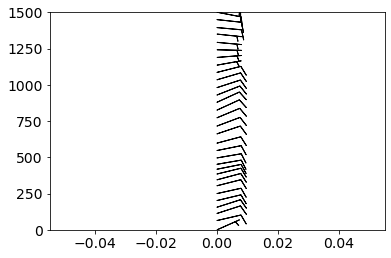

In [8]:
plt.barbs(np.zeros(len(walt)), walt, u, v)
plt.ylim(0, 1500)


# Reanalysis data

In [9]:
class Location:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon


In [10]:
loc = Location('SMT', 72.6, -38.5)

In [11]:
centlat, centlon = loc.lat, loc.lon
lat1, lat2 = centlat - 40, 90
lon1, lon2 = centlon + 360 -50, centlon + 360 + 50

In [12]:
data_mslp = xr.open_dataset('../data/obs/SMT/e5.oper.an.sfc.128_151_msl.ll025sc.2019070100_2019073123.nc')
data_temp = xr.open_dataset('../data/obs/SMT/e5.oper.an.sfc.128_167_2t.ll025sc.2019070100_2019073123.nc')

In [13]:
# subset = dict(latitude=slice(lat2, lat1), longitude=slice(lon1, lon2), time=np.datetime64('2017-05-12T09:00:00'))
subset = dict(time=np.datetime64('2019-07-02T06:00:00'))


In [14]:
mslp = data_mslp.MSL.sel(**subset)/ 100
temp = data_temp.VAR_2T.sel(**subset) 

In [15]:
plev = np.arange(700, 1100, 4)

In [16]:
stime = pd.to_datetime(mslp.time.values).strftime('%Y-%m-%d %Hz')

# Plotting

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

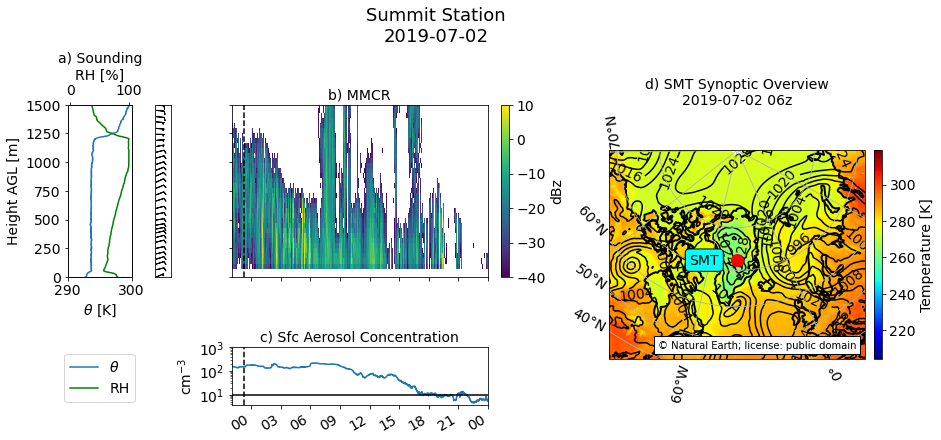

In [18]:
t1 = np.datetime64("2019-07-01T22:00:00")
t2 = np.datetime64("2019-07-03T00:00:00")
snd_time = smt_snd.time[0].values

fig = plt.figure(constrained_layout=True, figsize=(12,6))

gs = GridSpec(2, 4, figure=fig, height_ratios=[3,1], width_ratios=[1,0.25,4,4])

ax1 = fig.add_subplot(gs[0,0])
axl = fig.add_subplot(gs[1,0])
wind_ax = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,2])
ax4 = fig.add_subplot(gs[:,3], projection=ccrs.LambertConformal(central_latitude=centlat, central_longitude=centlon))

smt_theta = potential_temperature(smt_snd.pres * units["hPa"], smt_snd.tdry * units["degC"])

p1 = ax1.plot(smt_theta, smt_snd.alt - 3216, label='$\\theta$')
# p3 = ax1.plot(greenland_model_theta, greenland_model_heights, color='C0', linestyle='dashed')

# ax1.set_ylim(3216, 4816)
ax1.set_xlim(290, 300)
ax1.set_xlabel("$\\theta$ [K]")
ax1.set_title("a) Sounding")
ax1.set_ylim(0, 1500)

axrh = ax1.twiny()
p2 = axrh.plot(smt_snd.rh, smt_snd.alt - 3216, color='g', label='RH')
axrh.set_xlabel('RH [%]')
axrh.set_xticks([0,100])

lns = p1 + p2
labs = [l.get_label() for l in lns]
axl.legend(lns, labs, loc='upper center')
axl.spines['top'].set_visible(False)
axl.spines['right'].set_visible(False)
axl.spines['bottom'].set_visible(False)
axl.spines['left'].set_visible(False)
axl.get_xaxis().set_ticks([])
axl.get_yaxis().set_ticks([])

ax1.set_ylabel('Height AGL [m]')

# wind barbs
# divider = make_axes_locatable(ax1)
# wind_ax = divider.new_horizontal(size='50%', pad=2)
wind_ax.sharey(ax1)
wind_ax.get_xaxis().set_visible(False)
wind_ax.get_yaxis().set_visible(False)
fig.add_axes(wind_ax)
wind_ax.barbs(np.repeat(0, len(u)), walt, u, v, length=4)
wind_ax.set_xlim(-0.5, 4)

rad = smt_rad.refl_mode1.where(smt_rad.refl_mode1 >= -40).sel({'time':slice(t1,t2)}).plot.pcolormesh(
    ax=ax2, x='time', y='height',  
    shading="auto", vmin=-40, vmax=10, 
    add_colorbar=False, add_labels=False
)

# ax2.sharey(ax1)
# ax2.sharex(ax3)
ax2.set_ylim(0, 1500)
# ax2.set_yticklabels([])
plt.colorbar(rad, ax=ax2, label='dBz')
ax2.set_title("b) MMCR")
# ax2.set_ylabel('Height [m]')
ax2.set_xticklabels([""])
ax2.set_yticklabels([""])
# ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Hz"))
# ax2.sharex(ax3)
ax2.axvline(snd_time, color='k', linestyle='dashed')

smt_ccn.sel(dict(time = slice(t1,t2))).plot(ax=ax3, yscale='log')
# ax3.sharex(ax2)
ax3.set_xlim(t1, t2)
ax3.set_title("c) Sfc Aerosol Concentration")
# ax3.set_xticklabels(ax3.get_xticks(), rotation=45, ha="right")
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax3.set_xlabel("Hour UTC")
ax3.set_ylabel('cm$^{-3}$')
ax3.set_xlabel("")
ax3.set_yticks([10, 100, 1000])
ax3.axhline(10, color='k')
ax3.axvline(snd_time, color='k', linestyle='dashed')

# Synoptic plot
cartopy_transform = ccrs.PlateCarree()._as_mpl_transform(ax4)
text_transform = offset_copy(cartopy_transform, units='inches', x=-0.25, fig=fig)
ax4.set_extent((lon1, lon2, lat1, lat2))

t = ax4.pcolormesh(temp.longitude, temp.latitude, temp, transform=ccrs.PlateCarree(), cmap='jet')
p = ax4.contour(mslp.longitude, mslp.latitude, mslp, transform=ccrs.PlateCarree(), colors='k', levels=plev)

ax4.clabel(p, inline=True,zorder=1)

gl = ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False
gl.right_labels=False
gl.geo_labels=False

text_kwargs = dict(verticalalignment='center', horizontalalignment='right', transform=text_transform,
        bbox={
            'facecolor':'aqua',
            'alpha' : 1,
            'boxstyle' : 'round',
            'zorder':10
        }
)
ax4.plot(loc.lon, loc.lat, marker='o', color='red', markersize=12, transform=ccrs.PlateCarree())
ax4.text(loc.lon, loc.lat, loc.name, **text_kwargs)

ax4.coastlines(color='k', linewidth=2)
ax4.set_title(f"d) {loc.name} Synoptic Overview\n{stime}")

text = AnchoredText('© Natural Earth; license: public domain',
                    loc=4, prop={'size': 10}, frameon=True)
ax4.add_artist(text)

plt.suptitle("Summit Station\n2019-07-02")

plt.draw()
posn = ax4.get_position()
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0, 0.01, posn.height])

plt.colorbar(t, label='Temperature [K]', cax=cbar_ax)

plt.savefig('./fig04.png', facecolor='w', dpi=300)